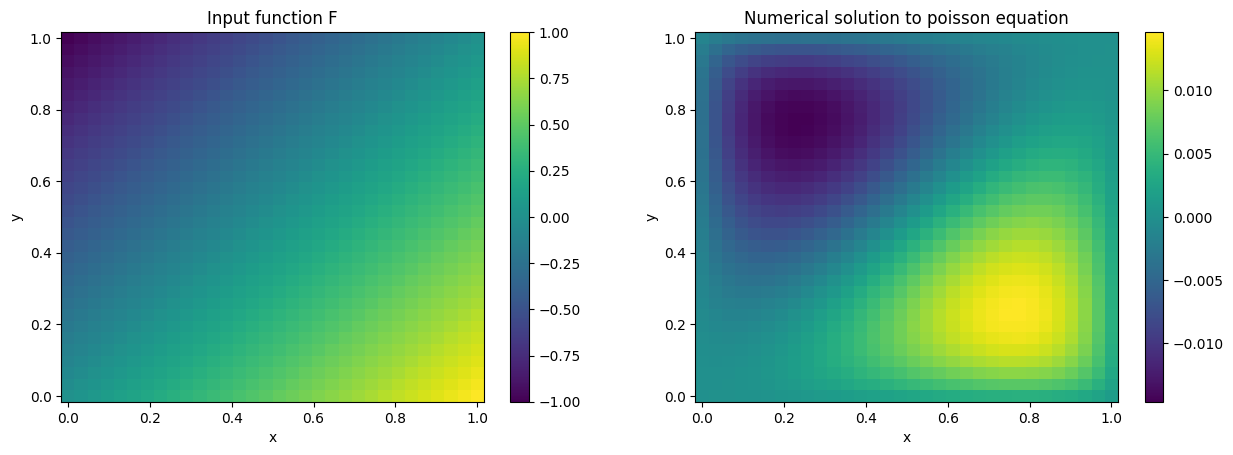

torch.Size([1, 1, 32, 32])


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X - Y
#F = X**2 + Y**2
#F = X*Y



#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:

import matplotlib.pyplot as plt
import sys, os

#from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss
#from neuralop.training import CheckpointCallback, BasicLoggerCallback
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.data_transforms import DefaultDataProcessor
from neuralop.datasets.transforms import PositionalEmbedding2D
import torch.nn.functional as F

from models.FNO_bayesian import FNO2D_Bayesian
from data_transforms import positional_embedding
from losses.nll import NLL


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

cuda


In [3]:
model = FNO2D_Bayesian(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.relu)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4786498 parameters.


In [4]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma = 0.5)

# Creating the losses

train_loss = NLL

sys.stdout.flush()

In [5]:
x_train = torch.load('../../data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
grid_boundaries = [[0,1],[0,1]]

x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)
y_train = y_train.unsqueeze(1)
train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

for ele in train_loader:
    print(ele[0].shape)
    print(ele[1].shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 1, 32, 32])


In [6]:
#test set
x_test = torch.load('../../data_poisson/dirichlet_test_100_32_x.pt').clone().type(torch.FloatTensor)
y_test = torch.load('../../data_poisson/dirichlet_test_100_32_y.pt').clone().type(torch.FloatTensor)

x_test = PositionalEmbedding2D([[0,1],[0,1]])(x_test)
y_test = y_test.unsqueeze(1)

test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )
#test_loader = {"100":test_loader}
eval_loss = train_loss

In [7]:
from callbacks.checkpointcallback import CheckpointCallback

ckpt = CheckpointCallback(save_dir='./checkpoints',
                                       save_freq=50)

from training.trainer import Trainer
trainer = Trainer(model=model, n_epochs=301,
                  device=device,
                  callbacks=[ckpt],
                  log_test_interval=1,
                  verbose=True)

In [8]:

trainer.train(train_loader=train_loader,
              test_loaders=test_loader,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Train Epoch: 0 [0/10000 (0%)]	Loss: -0.020076
Train Epoch: 0 [100/10000 (1%)]	Loss: -0.055540
Train Epoch: 0 [200/10000 (2%)]	Loss: -0.106625
Train Epoch: 0 [300/10000 (3%)]	Loss: -0.198629
Train Epoch: 0 [400/10000 (4%)]	Loss: -0.304432
Train Epoch: 0 [500/10000 (5%)]	Loss: -0.334158
Train Epoch: 0 [600/10000 (6%)]	Loss: -0.389381
Train Epoch: 0 [700/10000 (7%)]	Loss: -0.557680
Train Epoch: 0 [800/10000 (8%)]	Loss: -0.504072
Train Epoch: 0 [900/10000 (9%)]	Loss: -0.501412
Train Epoch: 0 [1000/10000 (10%)]	Loss: -0.609417
Train Epoch: 0 [1100/10000 (11%)]	Loss: -0.672998
Train Epoch: 0 [1200/10000 (12%)]	Loss: -0.688156
Train Epoch: 0 [1300/10000 (13%)]	Loss: -0.883517
Train Epoch: 0 [1400/10000 (14%)]	Loss: -0.361763
Train Epoch: 0 [1500/10000 (15%)]	Loss: -0.600881
Train Epoch: 0 [1600/10000 (16%)]	Loss: -0.542679
Train Epoch: 0 [1700/10000 (17%)]	Loss: -0.508777
Train Epoch: 0 [1800/10000 (18%)]	Loss: -0.495313
Train Epoch: 0 [1900/10000 (19%)]	Loss: -0.427409
Train Epoch: 0 [2000/1

In [9]:
plt.plot(np.arange(0,301,1),callback.loss,"-")
plt.plot(np.arange(0,301,1),callback.val_loss,"-r")
plt.legend()
plt.show()

NameError: name 'callback' is not defined

tensor([[[[-1.1577e+01, -7.2632e+00,  1.0037e+01,  ...,  5.2306e+04,
            2.5570e+04,  1.1768e+04],
          [ 1.1671e+01, -9.9120e+00, -7.8921e+00,  ...,  8.4762e+03,
            1.7886e+04,  3.5738e+04],
          [ 4.6924e+01,  9.3606e+00, -7.4474e-01,  ...,  7.7531e+03,
            1.7814e+04,  5.2703e+04],
          ...,
          [ 5.0200e+04,  1.0037e+04,  5.7521e+03,  ..., -9.3391e+00,
           -6.9087e+00,  2.8055e+01],
          [ 3.2579e+04,  1.8596e+04,  1.2894e+04,  ...,  2.8159e+01,
           -1.0870e+01,  8.4159e+00],
          [ 1.0586e+04,  2.7272e+04,  3.9600e+04,  ...,  3.3850e+01,
           -7.8138e+00, -1.1529e+01]]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor(5543.7607, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)


C:\Users\frase\AppData\Local\Temp\ipykernel_28844\3121497359.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U = torch.tensor(U).to(device)


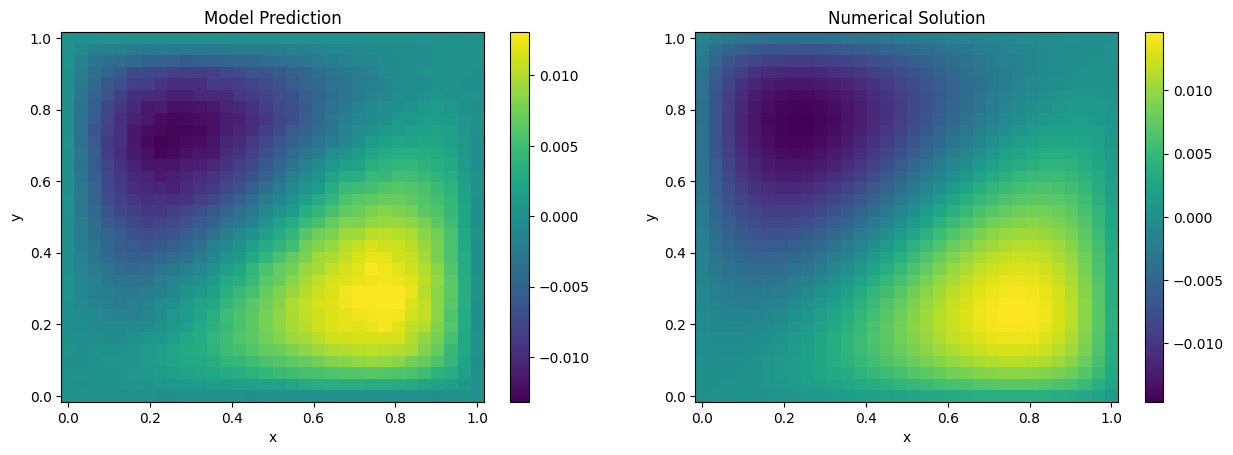

In [174]:
#prediction time
model.eval()
sample = torch.load("../finput.pt").clone().type(torch.FloatTensor).to(device)


#preprocessing
sample = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample)

out = model(sample)

U = torch.tensor(U).to(device)



def NLL_2(mean, log_var, targets):
    # Ensure positive variance using the softplus function
    var = torch.exp(log_var)
    nll_data = 0.5 * ((targets - mean) ** 2 / var)
    nll_var = 0.5 * torch.log(var)
    nll = nll_var + nll_data
    return nll

print(NLL_2(*out,U))

print(train_loss(*out,U))


actual_sample = torch.normal(out[0],torch.sqrt(torch.exp(out[1])))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,U.cpu())
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()


tensor([[[[-11.7562, -11.6205, -11.5702,  ..., -11.6677, -11.7040, -11.7758],
          [-11.4532,  -7.4447,  -6.9465,  ...,  -7.0499,  -7.8111, -11.6216],
          [-11.4929,  -4.6776,  -6.3147,  ...,  -5.2970,  -7.2119, -11.5967],
          ...,
          [-11.3263,  -6.5399,  -6.4346,  ...,  -6.9423,  -7.4883, -11.5478],
          [-11.2576,  -7.8150,  -6.1856,  ...,  -7.4043,  -8.1019, -11.6312],
          [-11.5966, -11.1653, -11.5073,  ..., -11.5218, -11.6057, -11.6697]]]],
       device='cuda:0', grad_fn=<AddBackward0>)


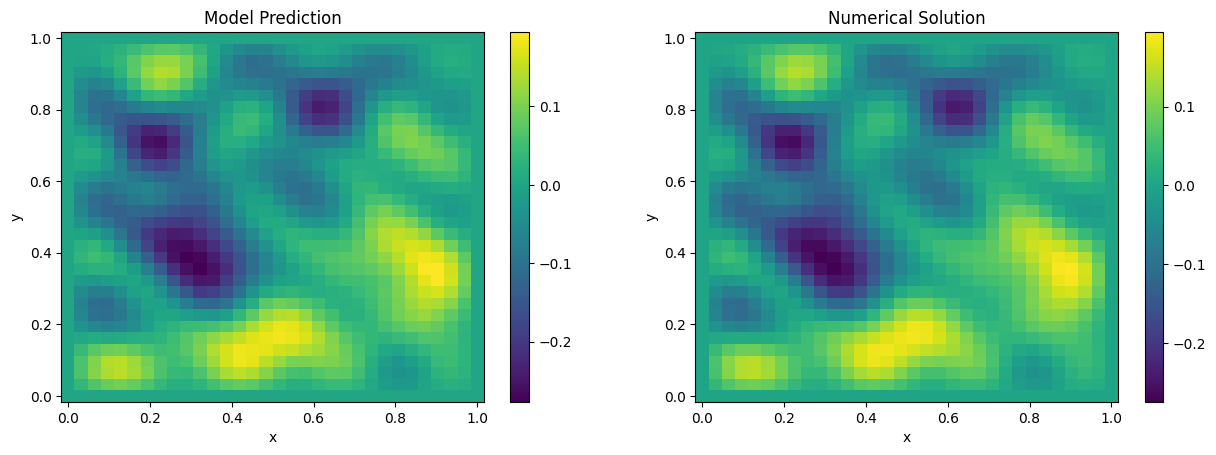

In [169]:
#prediction time
i = np.random.randint(0,10000)
sample = train_loader.dataset[i][0].unsqueeze(0).to(device)

#preprocessing
out = model(sample)



def NLL_2(mean, log_var, targets):
    # Ensure positive variance using the softplus function
    var = torch.exp(log_var)
    nll_data = 0.5 * ((targets - mean) ** 2 / var)
    nll_var = 0.5 * torch.log(var)
    nll = nll_var + nll_data
    return nll

#print(train_loss(*out,train_loader.dataset[i][1].to(device)))

print(NLL_2(*out,train_loader.dataset[i][1].to(device)))


actual_sample = torch.normal(out[0],torch.sqrt(torch.exp(out[1])))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,actual_sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,train_loader.dataset[i][1].unsqueeze(0)[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()
